<a href="https://colab.research.google.com/github/YujiSue/Research/blob/main/SmallObjectDetection/DetecionAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UNET segmentation for sparsed small objects detection

# Setup

In [ ]:
#@title Initialize
import os
import math
import numpy as np
import time
import cv2
import tensorflow as tf
from tensorflow import keras
from google.colab.patches import cv2_imshow
import IPython

seed = 8 #@param {type:'raw'}
np.random.seed = seed
tf.seed = seed

image_size = 64 #@param {type:'raw'}
epochs = 8 #@param {type:'raw'}
batch_size = 8 #@param {type:'raw'}

training_data_directory = '/content/Training' #@param {type:'string'}



In [ ]:
#@title Define splitter and assembler functions
#@markdown * splitter: A large image => Small square images
#@markdown * assembler: Small square images => A large image

# SPlitter function
def imgSplitter(img, length, margin, outdir, prefix, format):

  ## Prepare output directory
  os.makedirs(outdir, exist_ok=True)

  ## Estiamte the number of splitted images
  size = img.shape
  d = length - margin
  nrow = math.ceil((size[0] - margin) / d)
  ncol = math.ceil((size[1] - margin) / d)
  num = ncol * nrow

  ## Digit of the total number of splitted images
  dig = math.floor(math.log10(num)) + 1
  ori = np.array([0, 0])
  count = 1
  for r in range(0, nrow) :
    if size[0] < ori[0] + length:
      ori[0] = size[0] - length
    ori[1] = 0
    for c in range(0, ncol) :
      if size[1] < ori[1] + length:
        ori[1] = size[1] - length
      sub = img[ori[0]:ori[0] + length, ori[1]:ori[1] + length]
      output = os.path.join(outdir, prefix+"_"+str(count).zfill(dig)+"."+format)
      cv2.imwrite(output, sub)
      count = count + 1
      ori[1] += d
    ori[0] += d

def imgAssembler(size, length, margin, trim, indir, prefix, format):
  montage = np.zeros((size[0], size[1], size[2]))
  d = length - margin
  nrow = math.ceil((size[0] - margin) / d)
  ncol = math.ceil((size[1] - margin) / d)
  num = ncol * nrow
  dig = math.floor(math.log10(num)) + 1
  ori = np.array([0, 0])
  count = 1
  for r in range(0, nrow) :
    if size[0] < ori[0] + length:
        ori[0] = size[0] - length
    ori[1] = 0
    for c in range(0, ncol) :
      if size[1] < ori[1] + length:
        ori[1] = size[1] - length
      input = os.path.join(indir, prefix+"_"+str(count).zfill(dig)+"."+format)
      part = cv2.imread(input)
      montage[(ori[0] + trim):(ori[0] + length - trim), (ori[1] + trim):(ori[1] + length - trim)] = part[trim:(length - trim),trim:(length - trim)]
      count = count + 1
      ori[1] += d
    ori[0] += d
  output = os.path.join(indir, prefix+"_merge."+format)
  cv2.imwrite(output, montage)


def countObjects(img, min_threshold, max_threshold):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  ret, threshold = cv2.threshold(img, min_threshold, max_threshold, cv2.THRESH_BINARY)
  contours, hierarchy = cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  return len(contours)


# Preparation of training data

Training images should be located in the "/content/Training" directory, which has two subdirectories "ori" and "mask".   
The corresponding original image data and mask image should have the same name.   

```
/content
  |-- Training
        |-- ori
        |     |-- XXXX.tif
        |     |-- YYYY.tif
        |      ...
        |      
        |-- mask
              |-- XXXX.tif
              |-- YYYY.tif
               ...

```      

In [ ]:
#@title Download sample data
!wget https://github.com/YujiSue/Research/raw/main/SmallObjectDetection/egg_mask.zip &> /dev/null
!unzip egg_mask.zip &> /dev/null
!mv Egg_Mask Training

# Padding training images

In [ ]:
#@title Define functions

# Blightness and contrast
def blightVariation(img, alpha=1.0, beta=0.0):
  newimg = alpha * img + beta
  return np.clip(newimg, 0, 255).astype(np.uint8)

# Gamma correction
def gammmaCorrect(img, gamma):
  table = (np.arange(256) / 255) ** gamma * 255
  table = np.clip(table, 0, 255).astype(np.uint8)
  return cv2.LUT(img, table)

# Rotation
def rotatedImg(img):
  #180 degrees
  return cv2.rotate(img, cv2.ROTATE_180)

# Flip
def flippedImg(img):
  # [Vertical, Horizontal]
  return [cv2.flip(img, 0), cv2.flip(img, 1)]

# Padding training images
def makeVariation(imagef, maskf, dir, image_size, a1, a2, g1, g2):
  img = cv2.imread(imagef)
  mask = cv2.imread(maskf)
  label = os.path.splitext(os.path.split(imagef)[1])[0]
  mlabel = os.path.splitext(os.path.split(maskf)[1])[0]
  imgSplitter(img, image_size, image_size / 4, os.path.join(dir, "sample"), label, "jpg")
  imgSplitter(mask, image_size, image_size / 4, os.path.join(dir, "mask"), mlabel, "jpg")

  # blightness
  for a in range(a1, a2 + 1):
    tmp = blightVariation(img, a * 0.1, 0)
    imgSplitter(tmp, image_size, image_size / 4, os.path.join(dir, "sample"), label + "_a" + str(a), "jpg")

  # gammma
  for g in range(0, (g2 - g1) + 1):
    tmp = gammmaCorrect(img, 1.0 + 0.25 * (g + g1))
    imgSplitter(tmp, image_size, image_size / 4, os.path.join(dir, "sample"), label + "_g" + str(g), "jpg")

  # rotation
  tmp = rotatedImg(img)
  imgSplitter(tmp, image_size, image_size / 4, os.path.join(dir, "sample"), label + "_rot", "jpg")
  tmp = rotatedImg(mask)
  imgSplitter(tmp, image_size, image_size / 4, os.path.join(dir, "mask"), mlabel + "_rot", "jpg")

  # flip
  tmp = flippedImg(img)
  imgSplitter(tmp[0], image_size, image_size / 4, os.path.join(dir, "sample"), label + "_v", "jpg")
  imgSplitter(tmp[1], image_size, image_size / 4, os.path.join(dir, "sample"), label + "_h", "jpg")
  tmp = flippedImg(mask)
  imgSplitter(tmp[0], image_size, image_size / 4, os.path.join(dir, "mask"), mlabel + "_v", "jpg")
  imgSplitter(tmp[1], image_size, image_size / 4, os.path.join(dir, "mask"), mlabel + "_h", "jpg")


In [ ]:
#@title (Optional) Conversion of image format (TIFF => JPEG)
#from google.colab.patches import cv2_imshow
import glob
import os
files = glob.glob('/content/Training/*/*.tif')
for file in files:
  tif = cv2.imread(file)
  jpg = os.path.splitext(file)[0] + '.jpg'
  cv2.imwrite(jpg, tif)


In [ ]:
#@title Padding
#@markdown Set the range of brightness.
#@markdown Set the range of gamma value.

alpha_1 = 1 #@param
alpha_2 = 14 #@param
gamma_1 = -2 #@param
gamma_2 = 2 #@param

files = glob.glob('/content/Training/ori/*.jpg')
for file in files:
  mfile = file.replace('/ori/', '/mask/')
  images = makeVariation(file, mfile, os.path.join(training_data_directory, 'img'), image_size, alpha_1, alpha_2, gamma_1, gamma_2)


In [ ]:
#@title Selection of training images with objects
train_dataset = {}
files = glob.glob('/content/Training/img/sample/*')
for file in files:
  label = os.path.splitext(os.path.split(file)[1])[0]
  mfile = ''
  components = label.split('_')
  if len(components) == 3 and (components[1].startswith('a') or components[1].startswith('g')):
    mfile = os.path.join(os.path.split(file)[0].replace('/sample', '/mask'), components[0]+'_'+components[2]+os.path.splitext(os.path.split(file)[1])[1])
  else:
    mfile = file.replace('/sample/', '/mask/')
  mask_part = cv2.imread(mfile)
  if 0 < countObjects(mask_part, 127, 255):
    train_dataset[label] = [file, mfile]
print(len(train_dataset))

# Model Construction

In [ ]:
#@title Functions for building U-Net
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def unet4smallobj():
  f = [32, 64, 128, 256]
  inputs = keras.layers.Input((image_size, image_size, 3))
  p0 = inputs
  c1, p1 = down_block(p0, f[0])  # 128 --> 64
  c2, p2 = down_block(p1, f[1])  # 64  --> 32
  c3, p3 = down_block(p2, f[2])  # 32  --> 16
  bn = bottleneck(p3, f[3])

  u1 = up_block(bn, c3, f[2])  # 8  --> 16
  u2 = up_block(u1, c2, f[1])  # 16 --> 32
  u3 = up_block(u2, c1, f[0])  # 32 --> 64

  outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u3)

  model = keras.models.Model(inputs, outputs)
  return model

In [ ]:
#@title Model construction
model = unet4smallobj()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

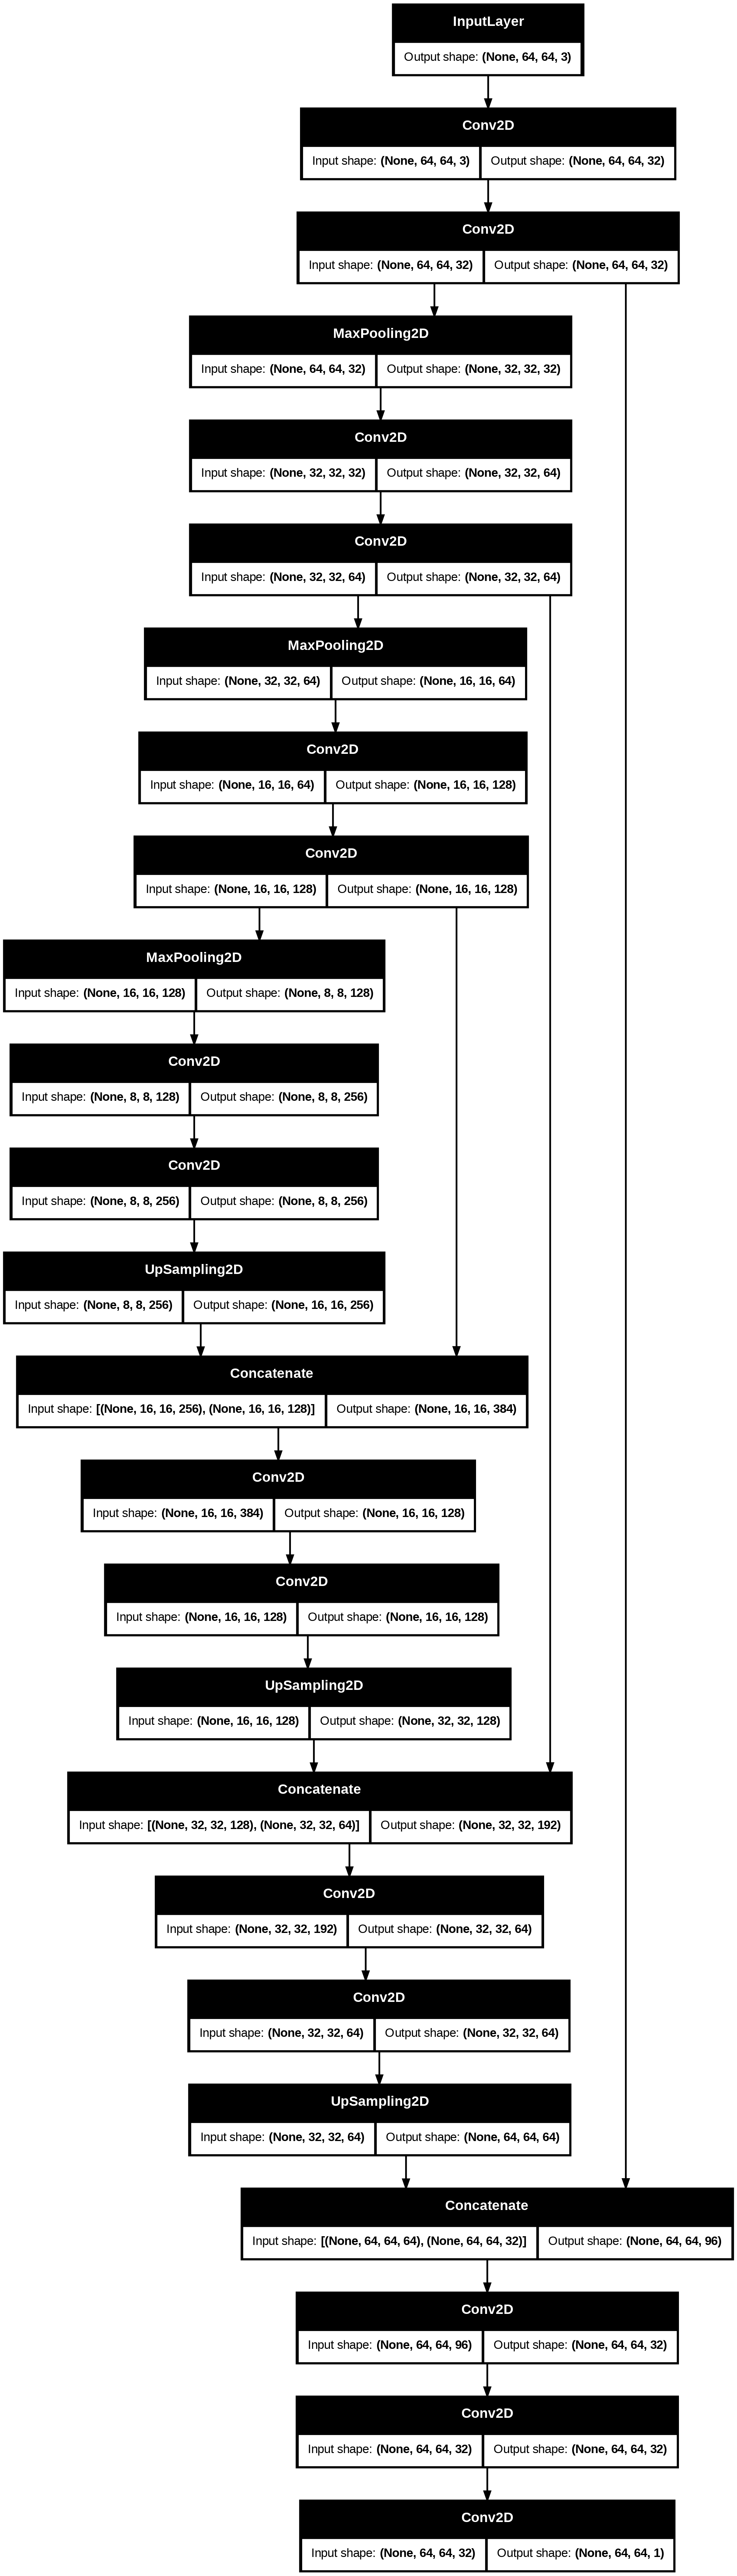

In [25]:
#@title Model visualization
from keras.utils import plot_model
keras.utils.plot_model(model, show_shapes=True, expand_nested=True)

# Training

In [ ]:
#@title Load funciton
def normalize(ori, mask):
  mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
  mask = np.expand_dims(mask, axis=-1)
  ori = ori/255.0
  mask = mask/255.0

class ImgGenerator(keras.utils.Sequence):
  def __init__(self, ids, dataset, batch_size, image_size):
    self.ids = ids
    self.dataset = dataset
    self.batch_size = batch_size
    self.image_size = image_size
    self.on_epoch_end()

  def __load__(self, id_name):
    image = cv2.imread(self.dataset[id_name][0], -1)
    mask = cv2.imread(self.dataset[id_name][1], -1)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = np.expand_dims(mask, axis=-1)
    image = image/255.0
    mask = mask/255.0
    return image, mask

  def __getitem__(self, index):
    if(index+1)*self.batch_size > len(self.ids):
      self.batch_size = len(self.ids) - index*self.batch_size
    files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
    images = []
    masks  = []
    for id_name in files_batch:
      _img, _mask = self.__load__(id_name)
      images.append(_img)
      masks.append(_mask)
    images = np.array(images)
    masks  = np.array(masks)
    return images, masks

  def on_epoch_end(self):
    pass

  def __len__(self):
    return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [ ]:
#@title Split data into training and validation data randomly
from sklearn.model_selection import train_test_split
valid_data_size = 500 #@param
train_labels = list(train_dataset.keys())
valid_label, train_label = train_test_split(train_labels, test_size=valid_data_size/len(train_labels))


In [ ]:
#@title Run
train_data = ImgGenerator(train_label, train_dataset, image_size = image_size, batch_size = batch_size)
valid_data = ImgGenerator(valid_label, train_dataset, image_size = image_size, batch_size = batch_size)
model.fit(train_data, validation_data = valid_data,
                    steps_per_epoch = len(train_label)//batch_size,
                    validation_steps = len(valid_label)//batch_size,
                    epochs = epochs)

In [ ]:
#@title Save the trained model
model_name = "mymodel" #@param {type:"string"}
model.save_weights(f"{model_name}.weights.h5")

# Test

In [ ]:
#@title (Optional) Download the model learned by author
!wget https://github.com/YujiSue/Research/raw/main/SmallObjectDetection/mymodel.h5

In [ ]:
#@title Load the learned model
model_name = "mymodel" #@param {type:"string"}
model.load_weights(f"{model_name}.weights.h5")

In [ ]:
#@title (Optional) Download the test image
!wget https://github.com/YujiSue/Research/raw/main/SmallObjectDetection/test.tif

In [ ]:
#@title Generate mask images for test data
def generateMask(file):
  split_img = cv2.imread(file)
  split_img = split_img / 255.0
  test_data = np.array([split_img])
  generated = model.predict(test_data)
  generated = generated[0]*255
  cv2.imwrite(os.path.join(predicted, os.path.split(file)[1]), generated)
###
input = 'test.tif' #@param{type:'string'}
split_dir = '/content/test'
predicted = '/content/predict'
#
test_img = cv2.imread(input, -1)
print(test_img.shape)
alpha = 255.0 / (np.max(test_img) - np.min(test_img))
test_img = test_img - np.min(test_img)
test_img = cv2.convertScaleAbs(test_img, alpha=alpha)
imgSplitter(test_img, image_size, image_size/4, split_dir, 'img', 'jpg')
os.makedirs(predicted, exist_ok=True)
files = glob.glob(os.path.join(split_dir, '*'))
files.sort()

for file in files:
  generateMask(file)

imgAssembler((test_img.shape[0], test_img.shape[1], 3), image_size, image_size/4, 2, predicted, "img", "jpg")

In [ ]:
#@title Count objects
threshold_area = 3.0 #@param
merged = cv2.imread(os.path.join(predicted, 'img_merge.jpg'))
merged = cv2.cvtColor(merged, cv2.COLOR_BGR2GRAY)
ret, threshold = cv2.threshold(merged, 127, 255, 0)
contours, hierarchy = cv2.findContours(threshold, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
cnts = []
for contour in contours:
  if threshold_area < cv2.contourArea(contour):
    cnts.append(contour)

origin = cv2.cvtColor(test_img, cv2.COLOR_GRAY2RGB)
output = cv2.drawContours(origin, cnts, -1, (255, 0, 255), 1)
for idx,contour in enumerate(cnts):
  cv2.putText(output, str(idx+1), contour[0][0], cv2.FONT_HERSHEY_PLAIN, 1, (255, 0, 255), 1, cv2.LINE_AA)

print('Count of object(s):',len(cnts))
print('Origin')
cv2_imshow(test_img)
print('Detected')
cv2_imshow(output)

# Reference

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "U-net: Convolutional networks for biomedical image segmentation." Medical Image Computing and Computer-Assisted Intervention–MICCAI 2015: 18th International Conference, Munich, Germany, October 5-9, 2015, Proceedings, Part III 18. Springer International Publishing, 2015.
  
* Bradski, G. (2000). The OpenCV Library. Dr. Dobb&#x27;s Journal of Software Tools.

# Citation
Not yet published.